# Import libraries and define helper functions

In [1]:
import os
import pandas as pd
import numpy as np
import pickle

def load_nctid2molecule_embedding_dict():
    with open('data/nctid2molecule_embedding_dict.pkl', 'rb') as pickle_file:
        return pickle.load(pickle_file)
        
def load_nctid2disease_embedding_dict():
    with open('data/nctid2disease_embedding_dict.pkl', 'rb') as pickle_file:
        return pickle.load(pickle_file)

def load_sponsor2embedding_dict():
    with open('data/sponsor2embedding_dict.pkl', 'rb') as pickle_file:
        return pickle.load(pickle_file)

def load_nctid2protocol_embedding_dict():
    with open('data/nctid_2_protocol_embedding_dict.pkl', 'rb') as pickle_file:
        return pickle.load(pickle_file)

# Import toy dataset

In [13]:
# Import toy dataset
toy_df = pd.read_pickle('data/toy_df_full.pkl')

train_df = toy_df[toy_df['split'] == 'train']
val_df = toy_df[toy_df['split'] == 'valid']
test_df = toy_df[toy_df['split'] == 'test']

y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

print(train_df.shape, val_df.shape, test_df.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1028, 14) (146, 14) (295, 14)
(1028,) (146,) (295,)


In [14]:
train_df[['nctid', 'phase', 'indications', 'drug_interventions', 'smiless', 'criteria', 'enrollment', 'lead_sponsor']].head()

,nctid,phase,indications,drug_interventions,smiless,criteria,enrollment,lead_sponsor
0,NCT00000378,Phase 4,"[Depression, Melancholia]","[Sertraline, Nortriptyline]",['CN[C@H]1CC[C@@H](C2=CC(Cl)=C(Cl)C=C2)C2=CC=C...,\n Inclusion Criteria:\r\n\r\n -...,110,New York State Psychiatric Institute
1,NCT00001656,Phase 4,"[Childhood Schizophrenia, Psychotic Disorder, ...","[Olanzapine, Clozapine]",['[H][C@]12[C@H](OC(=O)C3=CC=CC=C3)[C@]3(O)C[C...,\n - INCLUSION CRITERIA:\r\n\r\n ...,25,National Institute of Mental Health (NIMH)
2,NCT00002863,Phase 1,[Sarcoma],[chemotherapy],['NC1=NC(=O)N(C=C1)[C@@H]1O[C@H](CO)[C@@H](O)C...,\n DISEASE CHARACTERISTICS: Biopsy-prov...,19,University of Southern California
3,NCT00003060,Phase 1,[Melanoma (Skin)],"[busulfan, cyclophosphamide, cyclosporine, met...","['N[C@@H](CCCNC(N)=N)C(O)=O', '[H][C@@]12C[C@H...",\n DISEASE CHARACTERISTICS: Biopsy prov...,6,Louisiana State University Health Sciences Cen...
4,NCT00003567,Phase 1,"[Brain and Central Nervous System Tumors, Lymp...","[O6-benzylguanine, carmustine, temozolomide]","['N=C1NC2=C(N=CN2)C(OCC2=CC=CC=C2)=N1', 'ClCCN...",\n DISEASE CHARACTERISTICS:\r\n\r\n ...,8,Case Comprehensive Cancer Center


# Transform data into embeddings

In [20]:
def embed_all(df):
    print('input shape: ', df.shape)
    ### EMBEDDING MOLECULES ###
    print('embedding drug molecules..')
    nctid2molecule_embedding_dict = load_nctid2molecule_embedding_dict()
    h_m = np.stack(df['nctid'].map(nctid2molecule_embedding_dict)) 
    print(f"drug molecules successfully embedded into {h_m.shape} dimensions")
    ### EMBEDDING PROTOCOLS ###
    print('embedding protocols..')
    nctid2protocol_embedding_dict = load_nctid2protocol_embedding_dict()
    h_p = np.stack(df['nctid'].map(nctid2protocol_embedding_dict))
    print(f"protocols successfully embedded into {h_p.shape} dimensions")
    ### EMBEDDING DISEASE INDICATIONS ###
    print('embedding disease indications..')
    nctid2disease_embedding_dict = load_nctid2disease_embedding_dict()
    h_d = np.stack(df['nctid'].map(nctid2disease_embedding_dict))
    print(f"disease indications successfully embedded into {h_d.shape} dimensions")
    ### EMBEDDING TRIAL SPONSORS ###
    print('embedding sponsors..')
    sponsor2embedding_dict = load_sponsor2embedding_dict()
    h_s = np.stack(df['lead_sponsor'].map(sponsor2embedding_dict))
    print(f"sponsors successfully embedded into {h_s.shape} dimensions")
    ### EMBEDDING ENROLLMENT ###
    print('normalizing enrollment numbers..')
    enrollment = pd.to_numeric(df['enrollment'] , errors='coerce')
    if enrollment.isna().sum() != 0:
        print(f"filling {enrollment.isna().sum()} NaNs with median value")
        enrollment.fillna(int(enrollment.median()), inplace=True)
        print(f"succesfully filled NaNs with median value: {enrollment.isna().sum()} NaNs left")
    enrollment = enrollment.astype(int)
    h_e = np.array((enrollment - enrollment.mean())/enrollment.std()).reshape(len(df),-1)
    print(f"enrollment successfully embedded into {h_e.shape} dimensions")
    ### COMBINE ALL EMBEDDINGS ###
    embedded_df = pd.DataFrame(data=np.column_stack((h_m, h_p, h_d, h_s, h_e)))
    print('output shape: ', embedded_df.shape)
    return embedded_df

# Embed data
X_train = embed_all(train_df)
X_val = embed_all(val_df)
X_test = embed_all(test_df)

input shape:  (1028, 14)
embedding drug molecules..
drug molecules successfully embedded into (1028, 1024) dimensions
embedding protocols..
protocols successfully embedded into (1028, 624) dimensions
embedding disease indications..
disease indications successfully embedded into (1028, 312) dimensions
embedding sponsors..
sponsors successfully embedded into (1028, 384) dimensions
normalizing enrollment numbers..
enrollment successfully embedded into (1028, 1) dimensions
output shape:  (1028, 2345)
input shape:  (146, 14)
embedding drug molecules..
drug molecules successfully embedded into (146, 1024) dimensions
embedding protocols..
protocols successfully embedded into (146, 624) dimensions
embedding disease indications..
disease indications successfully embedded into (146, 312) dimensions
embedding sponsors..
sponsors successfully embedded into (146, 384) dimensions
normalizing enrollment numbers..
enrollment successfully embedded into (146, 1) dimensions
output shape:  (146, 2345)
inp

# Define evaluation metrics

In [16]:
# evaluation functions adapted from https://github.com/futianfan/clinical-trial-outcome-prediction
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, precision_score, recall_score, \
accuracy_score, roc_curve, precision_recall_curve

def evaluation(predict_all, label_all, threshold = 0.5):
    auc_score = roc_auc_score(label_all, predict_all)
    figure_folder = "figure"
    #### ROC-curve 
    fpr, tpr, thresholds = roc_curve(label_all, predict_all, pos_label=1)
    #### PR-curve
    precision, recall, thresholds = precision_recall_curve(label_all, predict_all)
    label_all = [int(i) for i in label_all]
    float2binary = lambda x:0 if x<threshold else 1
    predict_all = list(map(float2binary, predict_all))
    f1score = f1_score(label_all, predict_all)
    prauc_score = average_precision_score(label_all, predict_all)
    precision = precision_score(label_all, predict_all)
    recall = recall_score(label_all, predict_all)
    accuracy = accuracy_score(label_all, predict_all)
    predict_1_ratio = sum(predict_all) / len(predict_all)
    label_1_ratio = sum(label_all) / len(label_all)
    return auc_score, f1score, prauc_score, precision, recall, accuracy, predict_1_ratio, label_1_ratio 

def print_results(predict_all, label_all):
    print_num = 5
    auc_score, f1score, prauc_score, precision, recall, accuracy, \
    predict_1_ratio, label_1_ratio = evaluation(predict_all, label_all, threshold = 0.5)
    print("ROC AUC: " + str(auc_score)[:print_num] + "\nF1: " + str(f1score)[:print_num] \
         + "\nPR-AUC: " + str(prauc_score)[:print_num] \
         + "\nPrecision: " + str(precision)[:print_num] \
         + "\nrecall: "+str(recall)[:print_num] + "\naccuracy: "+str(accuracy)[:print_num] \
         + "\npredict 1 ratio: " + str(predict_1_ratio)[:print_num] \
         + "\nlabel 1 ratio: " + str(label_1_ratio)[:print_num])

# Train XGBoost and print results

In [18]:
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Create an XGBoost classifier with specified hyperparameters
xgb_classifier = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=200,
    objective='binary:logistic',  # for binary classification
    random_state=42
)

# Train the XGBoost model
xgb_classifier.fit(X_train, y_train)
# Make predictions
y_train_pred = xgb_classifier.predict(X_train)
y_val_pred = xgb_classifier.predict(X_val)
y_test_pred = xgb_classifier.predict(X_test)
print('-----------Results on training data:-----------')
print_results(y_train_pred, y_train)
print('-----------Results on validation data:-----------')
print_results(y_val_pred, y_val)
print('-----------Results on test data:-----------')
print_results(y_test_pred, y_test)

-----------Results on training data:-----------
ROC AUC: 1.0
F1: 1.0
PR-AUC: 1.0
Precision: 1.0
recall: 1.0
accuracy: 1.0
predict 1 ratio: 0.661
label 1 ratio: 0.661
-----------Results on validation data:-----------
ROC AUC: 0.765
F1: 0.817
PR-AUC: 0.799
Precision: 0.840
recall: 0.795
accuracy: 0.773
predict 1 ratio: 0.602
label 1 ratio: 0.636
-----------Results on test data:-----------
ROC AUC: 0.742
F1: 0.805
PR-AUC: 0.757
Precision: 0.790
recall: 0.821
accuracy: 0.759
predict 1 ratio: 0.630
label 1 ratio: 0.606


# Plot results and compare with HINT

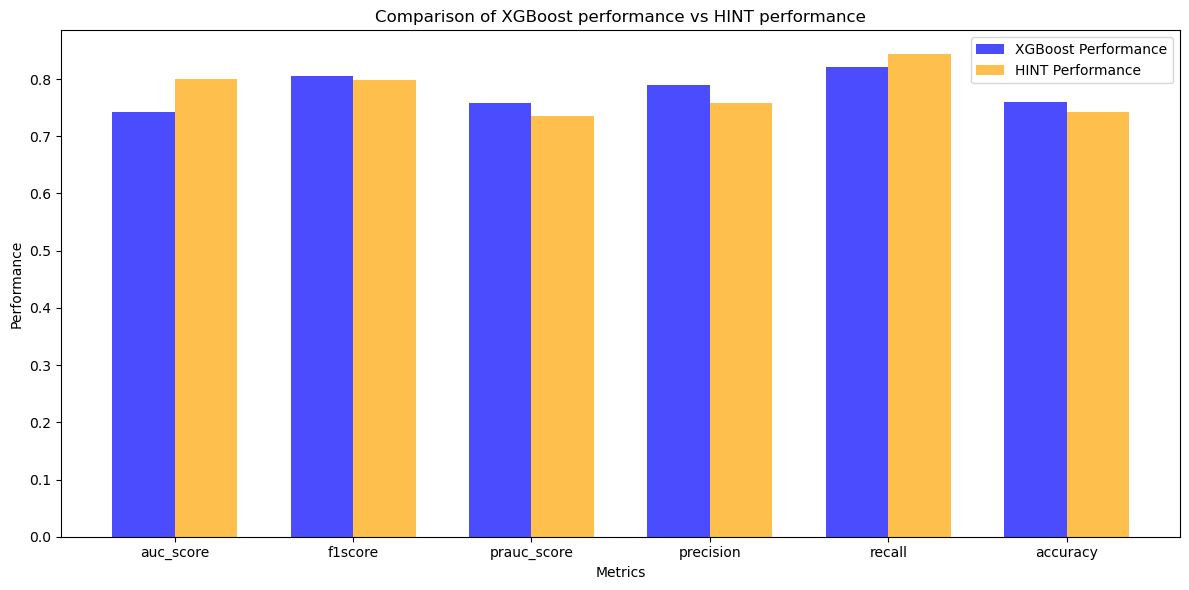

In [22]:
import matplotlib.pyplot as plt

HINT_performance = {'ROC AUC': 0.800, 'F1': 0.798, 'PR-AUC': 0.735, 'Precision': 0.758, 'recall': 0.843, 'accuracy': 0.742}

# Sample data for basic and improved performance for 5 metrics
metrics = ['auc_score', 'f1score', 'prauc_score', 'precision', 'recall', 'accuracy']
XGB_performance = evaluation(y_test_pred, y_test, threshold = 0.5)[:-2]
HINT_performance = list(HINT_performance.values())

# Width of each bar
bar_width = 0.35

# Create an array of indices for the metrics
indices = np.arange(len(metrics))

# Create the side-by-side bar chart
plt.figure(figsize=(12, 6))
plt.bar(indices - bar_width/2, XGB_performance, label='XGBoost Performance', width=bar_width, color='b', alpha=0.7)
plt.bar(indices + bar_width/2, HINT_performance, label='HINT Performance', width=bar_width, color='orange', alpha=0.7)

# Customize the chart
plt.xlabel('Metrics')
plt.ylabel('Performance')
plt.title('Comparison of XGBoost performance vs HINT performance')
plt.xticks(indices, metrics)
plt.legend()

# Show the chart
plt.tight_layout()
plt.show()